# 第9章: RNN, CNN
## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
seed = 123

In [3]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
#問題51で構築した学習データの確認
!head data/train.txt data/valid.txt data/test.txt

==> data/train.txt <==
TITLE	CATEGORY
update 0 us wins car import duties trade case against china	b
forex dollar gains against euro as draghi hints at action	b
will smith   willow smith causes a stir with controversial bed photo	e
qatar reprises distressed investor role with deutsche funds  0 	b
update 0 gm to invest  0 bln in china and plans more plants	b
update 0 vietnam vows tough measures to avert anti china unrest	b
paying it forward  shopper  0  buys  0 worth of diapers for cash strapped     	b
most emerging market stocks advance before us payroll report	b
mcdonald s offering free coffee for two weeks in taco bell breakfast war	b

==> data/valid.txt <==
TITLE	CATEGORY
european factors to watch shares seen steady at open  bnp in focus	b
mega upload founder kim dotcom sued by six of the biggest film studios     	e
caribbean competition drags down carnival s profit forecast	b
miley cyrus   miley cyrus stays sober on tour	e
israel readies for passover  marking egypt exodus	e
ryanair 

- 手順
  - ID番号をつける
    1. ファイルから文字列を取得
    2. 特徴量とラベルでデータを分ける
    3. 特徴量の単語を全てリストに格納する
    4. collectionsモジュールのCounter関数を使用する
    5. sorted()関数でバリューの降順でタプルとして並び替える
    6. タプルの降順にID番号を付与することで新たな辞書を作成
    7. 中間生成物としてpickleで保存
  - 単語列を入力としてID番号の列をを出力とする関数を定義
    1. 単語に対応する辞書のキーが存在していればバリューを返す
    2. 全ての単語に対して1を適用して、結果をリストに格納していく
    3. 得られたリストを返す

In [5]:
###ファイルから文字列を取得###
with open('data/train.txt') as tr, open('data/valid.txt') as va, open('data/test.txt') as te: 
    train, valid, test = tr.readlines()[1:], va.readlines()[1:], te.readlines()[1:]

In [6]:
#特徴量とラベルを分ける関数を定義
def feature_label(lis):
    X, y = [], []
    for i in range(len(lis)):
        X.append(lis[i].split('\t')[0])
        y.append(lis[i].split('\t')[1])
    return X, y

In [7]:
###特徴量とラベルを分ける関数を適用###
X_train, y_train = feature_label(train)
X_valid, y_valid = feature_label(valid)
X_test, y_test = feature_label(test)

#確認
print(f'訓練データの特徴量数：{len(X_train)}、訓練データのラベル数：{len(y_train)}')
print(f'検証データの特徴量数：{len(X_valid)}、検証データのラベル数：{len(y_valid)}')
print(f'テストデータの特徴量数：{len(X_test)}、テストデータのラベル数：{len(y_test)}')

訓練データの特徴量数：10671、訓練データのラベル数：10671
検証データの特徴量数：1334、検証データのラベル数：1334
テストデータの特徴量数：1334、テストデータのラベル数：1334


In [8]:
###特徴量の単語をすべてリストに格納する###
X_feature = X_train + X_valid + X_test
word = []

#単語に分割
for i in range(len(X_feature)):
    word.append(X_feature[i].split())

#単語のリストを生成
word_list = sum(word, []) #なんで空のリストを最後に足し合わせる必要があるのだろうか

#確認
print(word_list[:5])

['update', '0', 'us', 'wins', 'car']


## sum()関数
- 第二引数は何も指定しないとint型の0
  - リストのリスト同士を結合したい場合は第二引数に空のリストを渡す必要がある
- 文字列型リストの要素同士を結合したい場合はjoin()を使うと速い

(https://docs.python.org/ja/3/library/functions.html?highlight=sum#sum)

In [9]:
###collectionsモジュールのCounter()関数を使用###
import collections
word_count = collections.Counter(word_list)

In [10]:
###sorted()関数でバリューの降順でタプルとして並び替える###
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)

In [11]:
#確認
print(word_count[:5], word_count[-5:])

[('0', 4733), ('to', 3581), ('s', 2514), ('in', 2400), ('the', 1976)] [('virtuous', 1), ('circle', 1), ('yang', 1), ('economics', 1), ('align', 1)]


## 無名関数
- 何？
  - 名前がない関数
- どう使う？
  - lambda 引数1, 引数2:式
- 何が嬉しい？
  - 関数を短い記述で定義できる
  
## Counter()
- 

In [12]:
###タプルの昇順にID番号を付与することで新たな辞書を作成###
ID_dic = {}
for i in range(len(word_count)):
    if word_count[i][1] > 2:
        ID_dic[word_count[i][0]] = i+1

In [13]:
#確認
#print(ID_dic)

In [14]:
import pickle

In [15]:
###中間生成物としてpickleで保存###
with open('work/ID_dict.pickle', 'wb') as f:
    pickle.dump(ID_dic, f)

In [16]:
###単語列を入力としてID番号の列を出力とする関数を定義###
def ID_output(wordlis):
    result = [ID_dic[wordlis[i]] if wordlis[i] in ID_dic else 0 for i in range(len(wordlis))] #単語に対応する辞書のキーが存在していればバリューを返す
    return result  #得られたリストを返す

In [17]:
#確認
ID_output(['0', 'align', 'i', 'あ'])

[1, 0, 100, 0]

In [18]:
print(X_train[0].split())

['update', '0', 'us', 'wins', 'car', 'import', 'duties', 'trade', 'case', 'against', 'china']


In [19]:
# 語彙サイズを1つ大きく
vocab_size = 4+1
emb_dim = 5
# padding_idx=0を追加
embeddings = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
sents = torch.tensor([[1, 2, 3, 4],
                     [1, 4, 0, 0]])
embed_sents = embeddings(sents)
print(embed_sents)
print(sents.shape, '->', embed_sents.shape)

tensor([[[ 0.6603, -0.2196, -0.3792,  0.7671, -0.4015],
         [ 0.6957, -1.8061,  1.8960, -0.1750,  1.3689],
         [-1.6033, -1.3250, -1.4096, -0.4076,  0.7953],
         [ 0.9985,  0.2212,  1.8319, -0.3378,  0.8805]],

        [[ 0.6603, -0.2196, -0.3792,  0.7671, -0.4015],
         [ 0.9985,  0.2212,  1.8319, -0.3378,  0.8805],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([2, 4]) -> torch.Size([2, 4, 5])


In [20]:
#特徴量の前処理
def feature_change(X):
    X = [string.split() for string in X]
    X = [torch.tensor(ID_output(word_lis)) for word_lis in X]
    return X

In [21]:
#ラベルの前処理
def label_change(y):
    dict_int = {'b\n': '0', 't\n': '1', 'e\n': '2','m\n': '3'}
    for key, value in dict_int.items():
        y = [label.replace(key, value) for label in y]
    y = [int(label) for label in y]
    return y

In [22]:
y_train = label_change(y_train)
y_valid = label_change(y_valid)
y_test = label_change(y_test)
X_train = feature_change(X_train)
X_valid = feature_change(X_valid)
X_test = feature_change(X_test)

## 81. RNNによる予測
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．


$$
\overrightarrow h_0 = 0,\\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$$


ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [23]:
###RNNを定義###
class myRNN(nn.Module):
    def __init__(self , dic_size, emd_size, hidden, output, layer):
        super().__init__()
        self.layer = layer
        self.hidden = hidden
        self.emb = nn.Embedding(dic_size, emd_size, padding_idx=0)
        self.rnn = nn.RNN(emd_size, hidden, layer, batch_first=True)
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        x = self.emb(x) #onehot->wordvec
        batch_size = x.size()[0]
        x_rnn, hn = self.rnn(x, torch.zeros(self.layer, batch_size, self.hidden)) #Noneは『torch.zeros(layer, batch_size(x.size(0)), hidden)』
        y = self.fc(x_rnn[:, -1, :])
        return y

In [24]:
#ハイパーパラメータを定義
dic_size, emb_size, hidden, output, layer = len(ID_dic)+1, 300, 50, 4, 2
activation = nn.Softmax(dim=1)

In [25]:
#datasetの定義
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        label = self.y[idx]

        return feature.clone().detach(), label

In [26]:
#datesetの確認
print(Mydatasets(X_train, y_train)[1])

(tensor([  54,   42,  124,  135,   31,    9,  179, 2055,   15,  415]), 0)


In [27]:
#datasetの生成
train = Mydatasets(X_train, y_train)
valid = Mydatasets(X_valid, y_valid)
test = Mydatasets(X_test, y_test)

In [28]:
print(train[0][0].unsqueeze(0)) #次元数を増やす
print(train[0][0].size()[0])
print(torch.zeros(1, 3, 5))

tensor([[  10,    1,   11,  395,  331, 2953, 3737,  538,  221,  135,   25]])
11
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [29]:
rnn_model = myRNN(dic_size, emb_size, hidden, output, layer)
for i in range(5):
    print(activation(rnn_model(train[i][0].unsqueeze(0))))
    print(torch.argmax(activation(rnn_model(train[i][0].unsqueeze(0)))))

tensor([[0.2269, 0.3185, 0.2059, 0.2488]], grad_fn=<SoftmaxBackward0>)
tensor(1)
tensor([[0.2508, 0.3496, 0.2211, 0.1785]], grad_fn=<SoftmaxBackward0>)
tensor(1)
tensor([[0.2120, 0.3770, 0.2024, 0.2086]], grad_fn=<SoftmaxBackward0>)
tensor(1)
tensor([[0.2511, 0.2899, 0.2264, 0.2325]], grad_fn=<SoftmaxBackward0>)
tensor(1)
tensor([[0.2882, 0.3471, 0.1965, 0.1682]], grad_fn=<SoftmaxBackward0>)
tensor(1)


In [30]:
print(train[0])

(tensor([  10,    1,   11,  395,  331, 2953, 3737,  538,  221,  135,   25]), 0)


## 82. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



In [31]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)

In [32]:
#正解率、損失を計算する関数を定義
def calculate_acc_loss(loss, outputs, feature, label, y_acc, y_loss):
        
    y_loss.append(loss)
    y_label = torch.argmax(activation(outputs), dim=1)
    acc = torch.sum(y_label == label) * 1.0 / len(feature)
    y_acc.append(acc)  
        
    return y_acc, y_loss

In [33]:
#エポックごとの正解率と損失を表示かつリストに格納
def print_createlist(string ,acc, los, acc_list, los_list):

    print(f'{string}データの正解率：{torch.tensor(acc).mean()*100}')
    acc_list.append(torch.tensor(acc).mean().detach().numpy().copy()*100)
    print(f'{string}データの損失：{torch.tensor(los).mean()}\n')
    los_list.append(torch.tensor(los).mean().detach().numpy().copy())
    
    return acc_list, los_list

In [34]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        rnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        rnn_model.eval()
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：65.34532928466797
訓練データの損失：0.9425491690635681

検証データの正解率：72.86356353759766
検証データの損失：0.8096944689750671

エポック数：2
訓練データの正解率：74.97891235351562
訓練データの損失：0.7085590362548828

検証データの正解率：76.01199340820312
検証データの損失：0.6696087718009949

エポック数：3
訓練データの正解率：79.09286499023438
訓練データの損失：0.5950667858123779

検証データの正解率：73.61318969726562
検証データの損失：0.7344800233840942

エポック数：4
訓練データの正解率：81.00459289550781
訓練データの損失：0.5415205359458923

検証データの正解率：75.41229248046875
検証データの損失：0.7054842114448547

エポック数：5
訓練データの正解率：83.64727020263672
訓練データの損失：0.46614545583724976

検証データの正解率：77.2863540649414
検証データの損失：0.666610836982727

エポック数：6
訓練データの正解率：84.93112182617188
訓練データの損失：0.43103790283203125

検証データの正解率：79.31034851074219
検証データの損失：0.6027783751487732

エポック数：7
訓練データの正解率：86.8990707397461
訓練データの損失：0.3841197192668915

検証データの正解率：79.01049041748047
検証データの損失：0.6750613451004028

エポック数：8
訓練データの正解率：86.5335922241211
訓練データの損失：0.38659414649009705

検証データの正解率：79.23538208007812
検証データの損失：0.7039141058921814

エポック数：9
訓練データの正解率：81.7542

In [35]:
#可視化関数
def visible(epoch_list, acc_list1, los_list1, acc_list2, los_list2):
    plt.figure()
    plt.title("Accuracy Rate")
    plt.plot(epoch_list, acc_list1, label='train')
    plt.plot(epoch_list, acc_list2, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('accuracyrate')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Loss")
    plt.plot(epoch_list, los_list1, label='train')
    plt.plot(epoch_list, los_list2, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

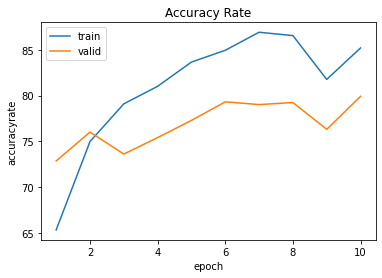

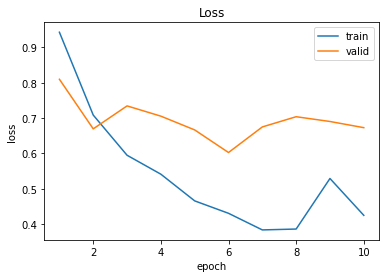

In [36]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 83. ミニバッチ化・GPU上での学習

問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．



In [37]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
def collate_fn(batch):
    sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.LongTensor([x[1] for x in sorted_batch])

    return sequences_padded, labels

In [39]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [40]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

rnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        rnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：86.27249145507812
訓練データの損失：0.41689079999923706

検証データの正解率：82.53373718261719
検証データの損失：0.6012054085731506

エポック数：2
訓練データの正解率：88.46514129638672
訓練データの損失：0.3493610620498657

検証データの正解率：82.9085464477539
検証データの損失：0.6308736205101013

エポック数：3
訓練データの正解率：88.74624633789062
訓練データの損失：0.334105521440506

検証データの正解率：81.48426055908203
検証データの損失：0.5860291123390198

エポック数：4
訓練データの正解率：90.49850463867188
訓練データの損失：0.2930736541748047

検証データの正解率：79.38530731201172
検証データの損失：0.6902260184288025

エポック数：5
訓練データの正解率：89.91754150390625
訓練データの損失：0.3164742887020111

検証データの正解率：81.03448486328125
検証データの損失：0.6361472606658936

エポック数：6
訓練データの正解率：89.99250793457031
訓練データの損失：0.30922847986221313

検証データの正解率：83.13343811035156
検証データの損失：0.6194121241569519

エポック数：7
訓練データの正解率：90.34857940673828
訓練データの損失：0.2946694791316986

検証データの正解率：80.95952606201172
検証データの損失：0.5864523649215698

エポック数：8
訓練データの正解率：91.6604232788086
訓練データの損失：0.25741010904312134

検証データの正解率：83.2083969116211
検証データの損失：0.5815446376800537

エポック数：9
訓練データの正解率：91.7541

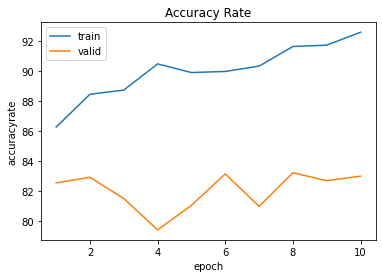

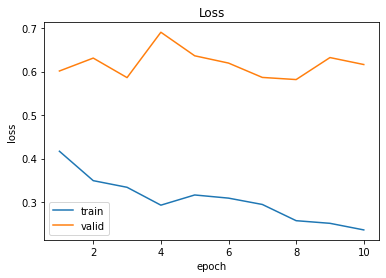

In [41]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．


In [42]:
from pymagnitude import Magnitude

In [43]:
#!wget -nc http://magnitude.plasticity.ai/word2vec/medium/GoogleNews-vectors-negative300.magnitude -P data/

In [44]:
model_m = Magnitude('data/GoogleNews-vectors-negative300.magnitude')
print(model_m.query('United_States'))

[-1.688670e-02 -2.259160e-02  1.099916e-01  8.169500e-02 -6.845950e-02
 -3.468620e-02 -4.746530e-02 -3.605530e-02  5.111640e-02 -2.669920e-02
 -6.937230e-02 -2.806840e-02  8.169500e-02 -3.605530e-02  1.209450e-02
 -3.582720e-02 -1.779950e-02  6.343920e-02  1.757130e-02 -1.962510e-02
 -1.665850e-02  2.498770e-02  1.720000e-04 -7.804390e-02 -5.476760e-02
  6.617750e-02 -7.941300e-02 -3.035040e-02 -7.804390e-02  4.700890e-02
  5.408300e-02 -1.022329e-01 -4.609610e-02 -1.198040e-02  5.750600e-02
 -1.654440e-02 -7.393630e-02 -7.484910e-02  1.374900e-02  3.810910e-02
  3.217600e-02  8.762820e-02  3.035040e-02  5.385480e-02 -1.061120e-02
  1.551749e-01 -1.528930e-02  8.306420e-02 -9.721250e-02  2.122250e-02
 -5.790500e-03  5.590860e-02  3.480000e-03 -4.221700e-03  5.339840e-02
  7.941300e-02 -1.113608e-01 -1.306440e-02 -5.659320e-02  1.158110e-02
  3.605530e-02 -1.317850e-02 -2.202110e-02  8.329200e-03 -5.750600e-02
 -2.487360e-02  1.255090e-02 -1.454760e-02 -2.612870e-02 -2.339030e-02
 -1.74

## 考え方
 1. 学習済ベクトルを埋め込み層にロードがしたい
 2. nn.Embedding.from_pretrainedを使用する
 3. これを使用するには『行番号が単語に割り振られたインデックス（ここでは辞書番号＝インデックス）に対応しているベクトル』を作る
 4. このベクトルをnn.Embedding.from_pretrainedの引数に与えてあげる

In [45]:
print(word_count[4][0])

the


In [46]:
#分散表現行列weigtの各行は単語のベクトルであり、「行番号が単語のインデックス(辞書番号)」と対応している。

weights = torch.tensor([model_m.query(word_count[i][0]) for i in range(len(word_count))]).float()

<ipython-input-46-0671ec3a6611>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/torch/csrc/utils/tensor_new.cpp:210.)
  weights = torch.tensor([model_m.query(word_count[i][0]) for i in range(len(word_count))]).float()


In [47]:
print(type(weights[0]))

<class 'torch.Tensor'>


In [48]:
def collate_fn(batch):
    sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.LongTensor([x[1] for x in sorted_batch])

    return sequences_padded.float(), labels

In [49]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [50]:
###RNNを定義###
class myRNN(nn.Module):
    def __init__(self , emd_size, hidden, output, layer, weights):
        super().__init__()
        self.layer = layer
        self.hidden = hidden
        self.emb = nn.Embedding.from_pretrained(weights, padding_idx=0)
        self.rnn = nn.RNN(emd_size, hidden, layer, batch_first=True)
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        x = self.emb(x).float() #onehot->wordvec
        batch_size = x.size()[0]
        x_rnn, hn = self.rnn(x, torch.zeros(self.layer, batch_size, self.hidden)) #Noneは『torch.zeros(layer, batch_size(x.size(0)), hidden)』
        y = self.fc(x_rnn[:, -1, :])
        return y

In [51]:
emb_size, hidden, output, layer = 300, 50, 4, 2
rnn_model = myRNN(emb_size, hidden, output, layer, weights)
rnn_model = rnn_model.float()

#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

rnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        rnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：42.353824615478516
訓練データの損失：1.1707844734191895

検証データの正解率：41.75412368774414
検証データの損失：1.151363730430603

エポック数：2
訓練データの正解率：49.13793182373047
訓練データの損失：1.1367303133010864

検証データの正解率：59.37031555175781
検証データの損失：1.0275030136108398

エポック数：3
訓練データの正解率：58.39580154418945
訓練データの損失：1.0574984550476074

検証データの正解率：51.12443542480469
検証データの損失：1.0948008298873901

エポック数：4
訓練データの正解率：62.01274490356445
訓練データの損失：1.0096176862716675

検証データの正解率：48.50074768066406
検証データの損失：1.347551703453064

エポック数：5
訓練データの正解率：63.60569763183594
訓練データの損失：0.9818742871284485

検証データの正解率：67.76612091064453
検証データの損失：0.8970361351966858

エポック数：6
訓練データの正解率：64.32720947265625
訓練データの損失：0.9651214480400085

検証データの正解率：67.69115447998047
検証データの損失：0.9151308536529541

エポック数：7
訓練データの正解率：65.48912811279297
訓練データの損失：0.9486833214759827

検証データの正解率：70.08995056152344
検証データの損失：0.8684687614440918

エポック数：8
訓練データの正解率：66.48238372802734
訓練データの損失：0.9295139908790588

検証データの正解率：70.23987579345703
検証データの損失：0.8536089658737183

エポック数：9
訓練データの正解率：66.9696

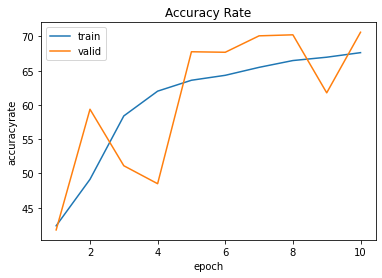

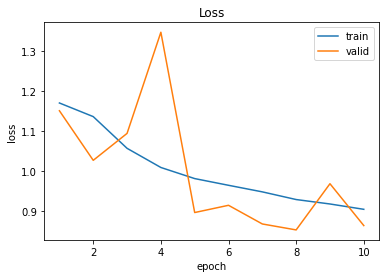

In [52]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．


In [53]:
###RNNを定義###
class myRNN(nn.Module):
    def __init__(self , emd_size, hidden, output, layer, weights):
        super().__init__()
        self.layer = layer
        self.hidden = hidden
        self.emb = nn.Embedding.from_pretrained(weights, padding_idx=0)
        self.rnn = nn.RNN(emd_size, hidden, layer, batch_first=True)
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        x = self.emb(x) #onehot->wordvec
        batch_size = x.size()[0]
        x_rnn, hn = self.rnn(x, torch.zeros(self.layer, batch_size, self.hidden)) #Noneは『torch.zeros(layer, batch_size(x.size(0)), hidden)』
        y = self.fc(x_rnn[:, -1, :])
        return y

In [54]:
emb_size, hidden, output, layer = 300, 50, 4, 2
rnn_model = myRNN(emb_size, hidden, output, layer, weights)
rnn_model = rnn_model.float()

#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

rnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        rnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = rnn_model(feature.long())  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：42.30697250366211
訓練データの損失：1.1708083152770996

検証データの正解率：44.977508544921875
検証データの損失：1.1493289470672607

エポック数：2
訓練データの正解率：47.31071853637695
訓練データの損失：1.1488102674484253

検証データの正解率：54.272865295410156
検証データの損失：1.1014946699142456

エポック数：3
訓練データの正解率：57.796104431152344
訓練データの損失：1.0654067993164062

検証データの正解率：63.19340515136719
検証データの損失：0.9753279685974121

エポック数：4
訓練データの正解率：61.647300720214844
訓練データの損失：1.0129163265228271

検証データの正解率：65.89205169677734
検証データの損失：0.934833824634552

エポック数：5
訓練データの正解率：62.9685173034668
訓練データの損失：0.9918192625045776

検証データの正解率：67.69115447998047
検証データの損失：0.9620694518089294

エポック数：6
訓練データの正解率：64.58020782470703
訓練データの損失：0.9601008296012878

検証データの正解率：68.21589660644531
検証データの損失：0.9040620923042297

エポック数：7
訓練データの正解率：65.50787353515625
訓練データの損失：0.9495037198066711

検証データの正解率：63.94302749633789
検証データの損失：0.9911661148071289

エポック数：8
訓練データの正解率：66.0044937133789
訓練データの損失：0.9365935325622559

検証データの正解率：57.19640350341797
検証データの損失：1.082343578338623

エポック数：9
訓練データの正解率：66.857

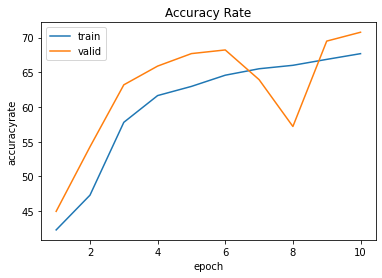

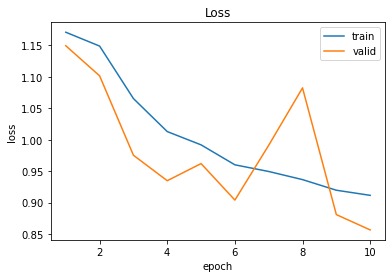

In [55]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 86. 畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
]
$$

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$

最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

In [56]:
subtrain = [train[i] for i in range(len(train)) if len(train[i][0]) > 2]
print(len(train), len(subtrain))

10671 10663


In [57]:
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.LongTensor([x[1] for x in batch])

    return sequences_padded.long(), labels

In [58]:
train_dataloader = torch.utils.data.DataLoader(subtrain, batch_size=1, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [59]:
class CNNnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding.from_pretrained(weights, padding_idx=0)
        self.pool = nn.MaxPool2d(1, 50)
        self.conv = nn.Conv2d(1, 50, (3, 300), stride=1, padding=0, bias=True)
        self.fc = nn.Linear(50, 4, bias=True)

    def forward(self, x):
        x = self.emb(x)
        #print(x.size())
        x = self.conv(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.pool(x)
        x = torch.unsqueeze(x, dim=0)
        x = torch.squeeze(x)
        #print(x.size())
        x = self.fc(x)
        return torch.unsqueeze(x, 0)

In [60]:
activation = nn.Softmax(dim=-1)

In [61]:
cnn_model = CNNnet()
for feature, label in train_dataloader:
    y = activation(cnn_model(feature))
    print(y)
    break

tensor([[0.2473, 0.2389, 0.2678, 0.2460]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ

In [62]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

cnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        cnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：57.26343536376953
訓練データの損失：1.051978588104248

検証データの正解率：64.09294891357422
検証データの損失：0.9379636645317078

エポック数：2
訓練データの正解率：65.59130096435547
訓練データの損失：0.9055342674255371

検証データの正解率：66.71664428710938
検証データの損失：0.880232572555542

エポック数：3
訓練データの正解率：68.58295440673828
訓練データの損失：0.8394582867622375

検証データの正解率：67.31634521484375
検証データの損失：0.8514860272407532

エポック数：4
訓練データの正解率：70.41170501708984
訓練データの損失：0.7918699383735657

検証データの正解率：69.64017486572266
検証データの損失：0.8234251141548157

エポック数：5
訓練データの正解率：71.0963134765625
訓練データの損失：0.7539796829223633

検証データの正解率：69.04047393798828
検証データの損失：0.8242834210395813

エポック数：6
訓練データの正解率：72.6624755859375
訓練データの損失：0.7152491211891174

検証データの正解率：69.86506652832031
検証データの損失：0.8111003041267395

エポック数：7
訓練データの正解率：74.59439086914062
訓練データの損失：0.6792858839035034

検証データの正解率：70.08995056152344
検証データの損失：0.8071768283843994

エポック数：8
訓練データの正解率：76.24495697021484
訓練データの損失：0.6432497501373291

検証データの正解率：70.61469268798828
検証データの損失：0.7994498014450073

エポック数：9
訓練データの正解率：77.6704483

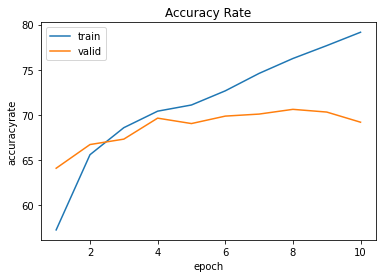

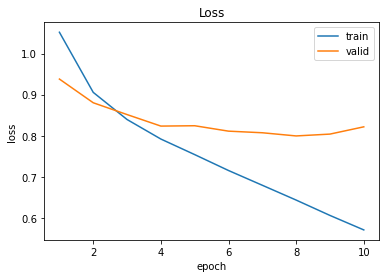

In [63]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 88. パラメータチューニング

問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [64]:
train_dataloader = torch.utils.data.DataLoader(subtrain, batch_size=1, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [65]:
class CNNnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding.from_pretrained(weights, padding_idx=0)
        self.pool1 = nn.MaxPool2d(1, 50)
        self.pool2 = nn.MaxPool2d(1, 25)
        self.conv1 = nn.Conv2d(1, 50, (3, 300), stride=1, padding=0, bias=True)
        self.conv2 = nn.Conv2d(50, 3, (1, 1), stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(3, 10, bias=True)
        self.fc2 = nn.Linear(10, 4, bias=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.emb(x)
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.pool1(x)
        
        x = self.conv2(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.pool2(x)
        x = torch.unsqueeze(x, dim=0)
        x = torch.squeeze(x)
        #print(x.size())
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.unsqueeze(x, 0)

In [66]:
cnn_model = CNNnet()
for feature, label in train_dataloader:
    y = activation(cnn_model(feature))
    print(y)
    break

tensor([[0.2234, 0.1958, 0.2004, 0.3805]], grad_fn=<SoftmaxBackward0>)


In [67]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

cnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        cnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：41.076622009277344
訓練データの損失：1.171904444694519

検証データの正解率：43.77811050415039
検証データの損失：1.1447962522506714

エポック数：2
訓練データの正解率：55.256492614746094
訓練データの損失：1.07037353515625

検証データの正解率：64.91754150390625
検証データの損失：0.9623293876647949

エポック数：3
訓練データの正解率：65.60067749023438
訓練データの損失：0.9316269159317017

検証データの正解率：66.41679382324219
検証データの損失：0.8845635652542114

エポック数：4
訓練データの正解率：68.4047622680664
訓練データの損失：0.8652235865592957

検証データの正解率：68.44078063964844
検証データの損失：0.862423300743103

エポック数：5
訓練データの正解率：70.98377227783203
訓練データの損失：0.7993330955505371

検証データの正解率：67.54122924804688
検証データの損失：0.8438098430633545

エポック数：6
訓練データの正解率：72.69998931884766
訓練データの損失：0.7330060601234436

検証データの正解率：66.04197692871094
検証データの損失：0.9978116750717163

エポック数：7
訓練データの正解率：74.556884765625
訓練データの損失：0.6760262250900269

検証データの正解率：69.1904067993164
検証データの損失：0.8578848242759705

エポック数：8
訓練データの正解率：76.47941589355469
訓練データの損失：0.6186725497245789

検証データの正解率：67.54122924804688
検証データの損失：0.8622835278511047

エポック数：9
訓練データの正解率：77.867393493

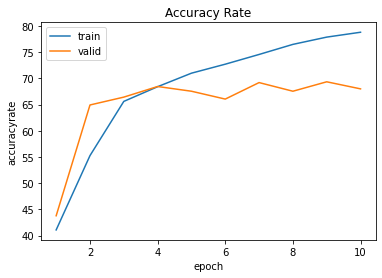

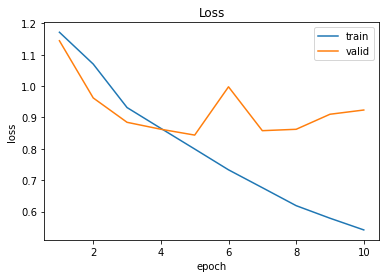

In [68]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## ドロップアウトの効果
＜ドロップアウトあり＞
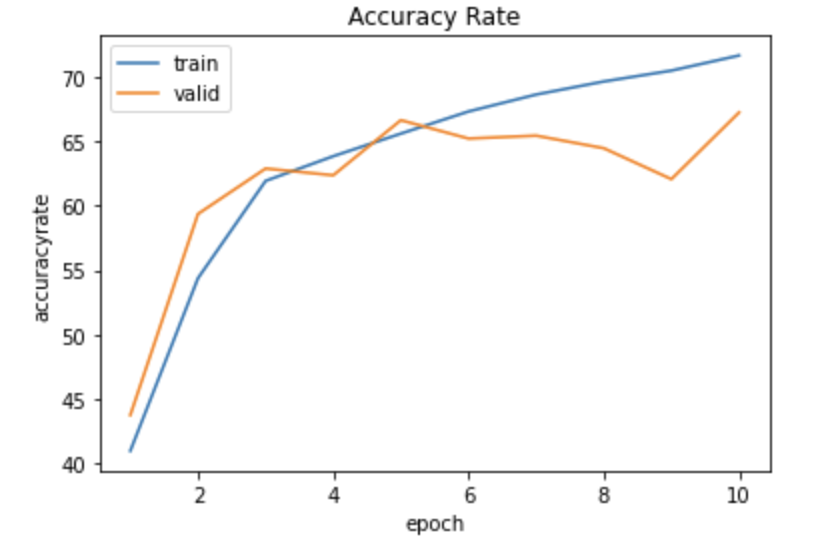

＜ドロップアウトなし＞
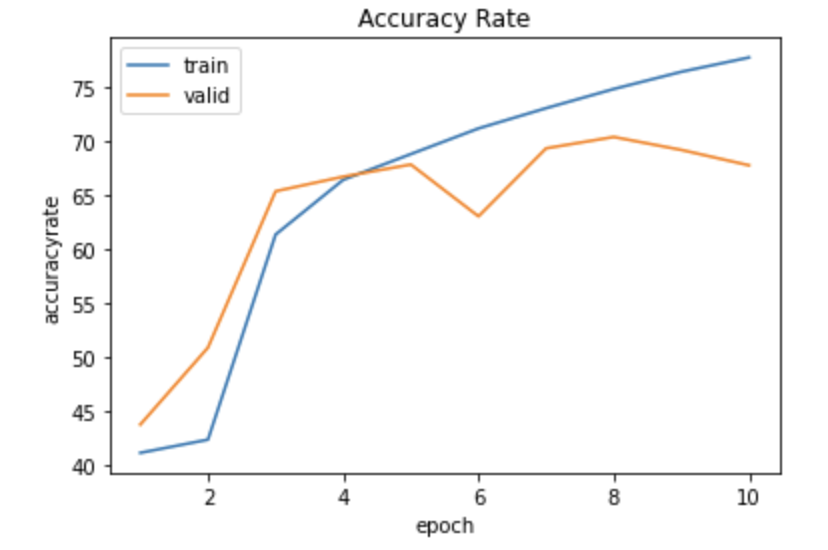

In [69]:
train_dataloader = torch.utils.data.DataLoader(subtrain, batch_size=1, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [70]:
class CNNnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding.from_pretrained(weights, padding_idx=0)
        self.pool1 = nn.MaxPool2d(1, 50)
        self.pool2 = nn.MaxPool2d(1, 25)
        self.conv1 = nn.Conv2d(1, 50, (3, 300), stride=1, padding=0, bias=True)
        self.conv2 = nn.Conv2d(50, 3, (1, 1), stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(3, 10, bias=True)
        self.fc2 = nn.Linear(10, 4, bias=True)

    def forward(self, x):
        x = self.emb(x)
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.pool1(x)
        
        x = self.conv2(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.pool2(x)
        x = torch.unsqueeze(x, dim=0)
        x = torch.squeeze(x)
        #print(x.size())
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.unsqueeze(x, 0)

In [71]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

cnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        cnn_model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, feature, label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        
        outputs = cnn_model(feature)  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, label)  # 手順2：正解ラベルとの比較
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, feature, label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：80.87779998779297
訓練データの損失：0.498970627784729

検証データの正解率：65.59220886230469
検証データの損失：0.9964852333068848

エポック数：2
訓練データの正解率：81.64682006835938
訓練データの損失：0.47750672698020935

検証データの正解率：67.24137878417969
検証データの損失：0.9659866094589233

エポック数：3
訓練データの正解率：82.72531127929688
訓練データの損失：0.45601585507392883

検証データの正解率：65.36731719970703
検証データの損失：1.0155426263809204

エポック数：4
訓練データの正解率：83.65375518798828
訓練データの損失：0.4335750639438629

検証データの正解率：67.0914535522461
検証データの損失：1.0505512952804565

エポック数：5
訓練データの正解率：84.225830078125
訓練データの損失：0.4160127341747284

検証データの正解率：67.9160385131836
検証データの損失：1.1744062900543213

エポック数：6
訓練データの正解率：84.90106201171875
訓練データの損失：0.39421120285987854

検証データの正解率：67.16641998291016
検証データの損失：1.1036690473556519

エポック数：7
訓練データの正解率：85.5669174194336
訓練データの損失：0.37827685475349426

検証データの正解率：65.21739196777344
検証データの損失：1.1054372787475586

エポック数：8
訓練データの正解率：86.39219665527344
訓練データの損失：0.3588027358055115

検証データの正解率：66.86656188964844
検証データの損失：1.173830509185791

エポック数：9
訓練データの正解率：86.148361

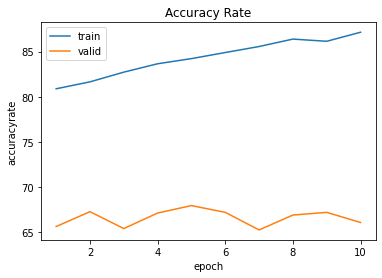

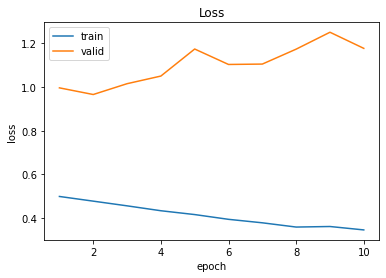

In [72]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)

## 89. 事前学習済み言語モデルからの転移学習

事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [73]:
import transformers
from transformers import BertModel 
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [74]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer(['I am a student.'], ['I am the student.']))

{'input_ids': [[101, 1045, 2572, 1037, 3076, 1012, 102, 1045, 2572, 1996, 3076, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## 考え方
1. タイトルの単語列を要素とするリストを用意
2. 特徴量のインデックスと対応したラベルのtensorデータを作る
3. データセットを作る
4. bertモデルを作る
5. 学習させる

In [75]:
#特徴量とラベルを分ける関数を定義
def feature_label(lis):
    X, y = [], []
    for i in range(len(lis)):
        X.append(lis[i].split('\t')[0])
        y.append(lis[i].split('\t')[1])
    return X, y

In [76]:
###ファイルから文字列を取得###
with open('data/train.txt') as tr, open('data/valid.txt') as va, open('data/test.txt') as te: 
    train, valid, test = tr.readlines()[1:], va.readlines()[1:], te.readlines()[1:]
    
X_train, y_train = feature_label(train)
X_valid, y_valid = feature_label(valid)
X_test, y_test = feature_label(test)

In [77]:
#ラベルの前処理
def label_change(y):
    dict_int = {'b\n': '0', 't\n': '1', 'e\n': '2','m\n': '3'}
    for key, value in dict_int.items():
        y = [label.replace(key, value) for label in y]
    y = [int(label) for label in y]
    return y

y_train = torch.tensor(label_change(y_train))
y_valid = torch.tensor(label_change(y_valid))
y_test = torch.tensor(label_change(y_test))

In [78]:
#datasetの定義
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        label = self.y[idx]

        return feature, label

In [79]:
train = Mydatasets(X_train, y_train)
valid = Mydatasets(X_valid, y_valid)

In [80]:
print(train[0])

('update 0 us wins car import duties trade case against china', tensor(0))


In [81]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=1024, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=1024, shuffle=True)

In [82]:
#ニューラルネットワーク構築
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
        
    def forward(self, x, y):
        y = self.bert(torch.tensor(x['input_ids']), attention_mask=torch.tensor(x['attention_mask']), token_type_ids=torch.tensor(x['token_type_ids']), labels=y)
        return y['loss'], y['logits']
    
model = NeuralNetwork()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [83]:
#正解率、損失を計算する関数を定義
def calculate_acc_loss(loss, outputs, feature, label, y_acc, y_loss):
        
    y_loss.append(loss)
    y_label = torch.argmax(activation(outputs), dim=1)
    acc = torch.sum(y_label == label) * 1.0 / len(feature)
    y_acc.append(acc)  
        
    return y_acc, y_loss

In [ ]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

EPOCHS = 10
epoch_list, acc_tra_list, los_tra_list = [], [], []
acc_vali_list, los_vali_list = [], []

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", return_tensors="pt")

cnn_model.to(device)
for epoch in range(EPOCHS):
    acc_tra, acc_vali = [], [] 
    los_tra, los_vali = [], []
    for feature, label in train_dataloader:
        
        model.train()
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        x = tokenizer(feature, padding=True)
        loss, outputs = model(x, label)  # 手順1：ニューラルネットワークにデータを入力
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
        
        #損失と正解率を計算
        acc_tra, los_tra = calculate_acc_loss(loss, outputs, x['input_ids'], label, acc_tra, los_tra)
        
    # 全体の平均を算出
    print(f'エポック数：{epoch+1}')
    epoch_list.append(epoch+1)
    acc_tra_list, los_tra_list = print_createlist('訓練', acc_tra, los_tra, acc_tra_list, los_tra_list)
    
    for feature, label in valid_dataloader:
        x = tokenizer(feature, padding=True)
        loss, outputs = model(x, label)  # 手順1：ニューラルネットワークにデータを入力
        
        #損失と正解率を計算
        acc_vali, los_vali = calculate_acc_loss(loss, outputs, x['input_ids'], label, acc_vali, los_vali)
        
    # 全体の平均を算出
    acc_vali_list, los_vali_list = print_createlist('検証', acc_vali, los_vali, acc_vali_list, los_vali_list)

エポック数：1
訓練データの正解率：61.28975296020508
訓練データの損失：0.951121985912323

検証データの正解率：82.67023468017578
検証データの損失：0.47536346316337585

エポック数：2
訓練データの正解率：85.71619415283203
訓練データの損失：0.43679699301719666

検証データの正解率：89.3928451538086
検証データの損失：0.324261337518692



In [ ]:
visible(epoch_list, acc_tra_list, los_tra_list, acc_vali_list, los_vali_list)